LIBRARIES USED

In [2]:
#Importing required libraries

import re
import time
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from getpass import getpass
from bs4 import BeautifulSoup
from selenium import webdriver
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.utils import resample
from selenium.webdriver.common.by import By
from sklearn.tree import DecisionTreeRegressor
from selenium.webdriver.common.keys import Keys
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor

Downloading list of highest rated players from the website "fotmob.com"   
Note: returns the detail of 10 players only, thus, it was run manually for next 32 pages to get the 328 players list

In [3]:
#website for scraping under url
url = "https://www.fotmob.com/leagues/61/stats/season/23826/players/rating/liga-portugal"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
response = requests.get(url, headers=headers)
response            #2** means successful else if 4** then no response

<Response [200]>

In [5]:
#check the contents of response
response.content

<Response [200]>

In [6]:
#Initializing an instance of webdriver
driver = webdriver.Edge()
driver.get("https://www.fotmob.com/leagues/61/stats/season/23826/players/rating/liga-portugal")
driver.maximize_window()
consent = driver.find_element(By.CLASS_NAME, "fc-button-label")
consent.click()
html = driver.page_source

In [7]:
html= driver.page_source
soup = BeautifulSoup(html)

In [10]:
body = driver.find_element(By.TAG_NAME, "body")

for i in range(4):
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(.2)

#gathering content again
response = requests.get(url, headers=headers)

response.content

html = driver.page_source
soup = BeautifulSoup(html)
soup.prettify()

<Response [200]>

In [16]:
#code to find the next/previous button by xpath

next_page = driver.find_element(By.XPATH, "//*[@id=\"__next\"]/main/main/div[2]/div[2]/div/section/div[2]/div[2]/button[2]")
next_page.click()

# download the hrefs for highest rated players 
# "links to each player is stored in the href"

player_links = soup.find("div",attrs = {"class":"css-fvfi51-LeagueSeasonStatsTableCSS e15r3kn20"})
links = player_links.find_all("a")
texts = []
hrefs = []
for link in links:
    try:
        html = driver.page_source
        soup = BeautifulSoup(html)
        player_links = soup.find("div",attrs = {"class":"css-fvfi51-LeagueSeasonStatsTableCSS e15r3kn20"})
        links = player_links.find_all("a")
        text = link.text
        href = link.get("href")
        
        texts.append(text)
        hrefs.append(href)
    except:
        pass

player_list= {"text":texts,
              "href":hrefs}

df_players_list = pd.DataFrame(player_list)
# Saving the list into a csv file
#df_players_list.to_csv('players_list.csv', index=False)
df_players_list.head(3)

,text,href
0,21Zaydou YoussoufPlayer of the Match: 27.54,/players/813549/zaydou-youssouf
1,22Ze PedroPlayer of the Match: 07.54,/players/957107/ze-pedro
2,23Goncalo InacioPlayer of the Match: 07.51,/players/1165710/goncalo-inacio


DOWNLOAD THE LAST 10 COMPETITIVE MATCH DETAILS OF PLAYERS 

In [11]:
#Read the list of players name
df_players = pd.read_csv("players_list.csv")
df_players.head(3)

,text,href
0,1Viktor GyökeresPlayer of the Match: 19.14,/en-GB/players/664500/viktor-gyokeres
1,2Gabri MartinezPlayer of the Match: 08.89,/en-GB/players/1287941/gabri-martinez
2,3Pedro GoncalvesPlayer of the Match: 28.73,/en-GB/players/875133/pedro-goncalves


In [12]:
#Extracting the player ID  and name from the csv
df_players[['player_id', 'player_name']] = df_players['href'].str.extract(r'/players/(\d+)/(.*)')
df_players['player_name'] = df_players['player_name'].str.replace('-', ' ')
# Extract the 'player_id/player_name' portion
df_players['player_id_name'] = df_players['href'].str.extract(r'/players/(\d+/[a-zA-Z-]+)')
df_players = df_players.drop(columns="href")
df_players.head(3)

,text,player_id,player_name,player_id_name
0,1Viktor GyökeresPlayer of the Match: 19.14,664500,viktor gyokeres,664500/viktor-gyokeres
1,2Gabri MartinezPlayer of the Match: 08.89,1287941,gabri martinez,1287941/gabri-martinez
2,3Pedro GoncalvesPlayer of the Match: 28.73,875133,pedro goncalves,875133/pedro-goncalves


In [13]:
url = "https://www.fotmob.com/players/1070776/rodrigo-zalazar"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
response = requests.get(url, headers=headers)
response

<Response [200]>

In [ ]:
# Scraping data
player_stat_dict={}
base_url = 'https://www.fotmob.com/players/'
player_names=[]
players_teams=[]
players_bios=[]
players_positions=[]
players_traits=[]
players_liga_25s=[]
season_perfs=[]

for player in df_players['player_id_name']:
    try:
        # Send a GET request to the URL
        full_url = f"{base_url}{player}"
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
        response = requests.get(full_url, headers=headers)
        response.raise_for_status()  # Check for request errors
        t = random.uniform(0.50,0.70)*2
        time.sleep(t) 
        # Parse the HTML content with BeautifulSoup
        soup = BeautifulSoup(response.content)
        #Player name
        try:
            player_name = soup.find("h1", attrs= {"class":"css-zt63wq-PlayerNameCSS e3s3byw1"}).get_text()
        except AttributeError:
            player_name = None
        player_names.append(player_name)

        #  team
        try:
            players_team = soup.find("div", attrs={"class":"css-14k6s2u-TeamCSS e3s3byw2"}).get_text()
        except AttributeError:
            players_team = None
        players_teams.append(players_team)

        # class with player's bio
        try:
            players_bio = soup.find("div", attrs={"class":"css-qpoljv-BioContainerCSS e1pz3ljv1"}).get_text()
        except AttributeError:
            players_bio = None
        players_bios.append(players_bio)

        #Class with players position
        try:
            players_position = soup.find("div", attrs={"class":"css-s0c8mb-PlayerPositionCSS e1x6pspg0"}).get_text()
        except AttributeError:
            players_position = None
        players_positions.append(players_position)
        
        #Class with player traits
        try:
            players_trait = soup.find("div", attrs={"class":"css-1l78068-PlayerTraitsContent enw3yfw3"}).get_text()
        except AttributeError:
            players_trait = None
        players_traits.append(players_trait)

        #Player's season_24_25 so far
        try:
            players_liga_25 = soup.find("div", attrs={"class":"css-4yroh7-StatsContainer e1ahduwc1"}).get_text()
        except AttributeError:
            players_liga_25 = None
        players_liga_25s.append(players_liga_25)

        
        #SEASON PERFORMANCE so far (total)
        try:
            season_perf = soup.find("div", attrs={"class":"css-15lw8xy-SeasonPerformanceCSS e1uibvo19"}).get_text()
        except AttributeError:
            season_perf = None
        season_perfs.append(season_perf)

        
    except:
        pass

    player_stat_dict = {"player_name":player_names,
           "team": players_teams,
           "bio_stat": players_bios,
           "positions":players_positions,
           "traits":players_traits,
           "liga_25_stats":players_liga_25s,
           "season_performance":season_perfs}
    player_stat_dict
    t = random.uniform(0.50,0.75)*2
    time.sleep(t)
df_player_stats = pd.DataFrame.from_dict(player_stat_dict, orient="columns")

df_player_stats.head(3)


In [29]:
# saving player stats in a csv file
df_player_stats.to_csv("player_stats.csv", index = False)

DOWNLOAD PLAYER RATING DETAILS LAST 10 MATCH

In [19]:
# Scraping data

base_url = 'https://www.fotmob.com/players/'
# Initialize lists
player_names = []
match_day_details = []
match_stats = []
minutes_plays = []
goals_scoreds= []
assists = []
yellow_cards = []
red_cards = []
player_ratings = []

for player in df_players['player_id_name']:
    try:
        # Send a GET request to the URL
        full_url = f"{base_url}{player}"
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
        response = requests.get(full_url, headers=headers)
        response.raise_for_status()  # Check for request errors

        # Parse the HTML content with BeautifulSoup
        soup = BeautifulSoup(response.content)
        last_matches = soup.find("div", attrs={"class":"css-iho0mw-PlayerMatchStatsTableBody e1byptjh2"})


        for last_match in last_matches:
    
            try:
                player_name = soup.find("h1", attrs= {"class":"css-zt63wq-PlayerNameCSS e3s3byw1"}).get_text()
            except IndexError:
                player_name = None
            player_names.append(player_name)

        # Match day details
            try:
                match_day_detail = last_match.find("div", attrs={"class": "css-11pz4i7-LeftContent e1byptjh7"}).get_text()
            except AttributeError:
                match_day_detail = None
            match_day_details.append(match_day_detail)

        # Match stats
            try:
                match_stat = last_match.find("div", attrs={"class": "css-eam8ce-PlayerMatchStatsDataCSS e1byptjh10"}).get_text()
            except AttributeError:
                match_stat = None
            match_stats.append(match_stat)

            try:
                minutes_play = last_match.find_all("div", attrs = {"class":"css-1pgf5nj-DataCell e1byptjh11"})[0].get_text()
            except IndexError:
                minutes_play = None
            minutes_plays.append(minutes_play)

            try:
                goals_scored = last_match.find_all("div", attrs = {"class":"css-1pgf5nj-DataCell e1byptjh11"})[1].get_text()
            except IndexError:
                goals_scored = None
            goals_scoreds.append(goals_scored)

            try:
                assist = last_match.find_all("div", attrs = {"class":"css-1pgf5nj-DataCell e1byptjh11"})[2].get_text()
            except IndexError:
                assist = None
            assists.append(assist)

            try:
                yellow_card = last_match.find_all("div", attrs = {"class":"css-1bh523n-DataCell e1byptjh11"})[0].get_text()
            except IndexError:
                yellow_card = None
            yellow_cards.append(yellow_card)

            try:
                red_card = last_match.find_all("div", attrs = {"class":"css-1bh523n-DataCell e1byptjh11"})[1].get_text()
            except IndexError:
                red_card = None
            red_cards.append(red_card)

            try:
                player_rating = last_match.find_all("div", attrs = {"class":"css-1g8umax-DataCell e1byptjh11"})[0].get_text()
            except IndexError:
                player_rating = None
            player_ratings.append(player_rating)
    
            t = random.uniform(0.05,0.08)*2
            time.sleep(t)
                    
    except:
        pass

    # Construct the DataFrame
    my_dict = {
            "player_names": player_names,
            "matchday_details": match_day_details,
            "matchday_stats": match_stats,
            "minutes_played":minutes_plays,
            "goals_scored":goals_scoreds,
            "assists":assists,
            "yellow_cards":yellow_cards,
            "red_cards":red_cards,
            "player_ratings":player_ratings}

df_player_last_games = pd.DataFrame.from_dict(my_dict, orient="columns")

# Display the DataFrame 
df_player_last_games.head(3)


,player_names,matchday_details,matchday_stats,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings


In [ ]:
df_player_last_games.to_csv("player_last10_games_new.csv", index = False)

In [ ]:
df= pd.read_csv("player_last10_games.csv")

Download players ratings for matches 11 to 30
(This step was added later to obtain more match ratings after the 10 matches. We can modify the following code very little and use it to gather the players ratings from start and skip the previous step.)

In [ ]:
base_url = 'https://www.fotmob.com/players/'
# Initialize lists
player_names = []
match_day_details = []
match_stats = []
minutes_plays = []
goals_scoreds= []
assists = []
yellow_cards = []
red_cards = []
player_ratings = []

for player in df_players['player_id_name']:
    try:
        # Send a GET request to the URL
        full_url = f"{base_url}{player}"

        driver = webdriver.Edge()
        driver.get(full_url)
        driver.maximize_window()

        time.sleep(1)
        consent = driver.find_element(By.CLASS_NAME, "fc-button-label")
        consent.click()
        time.sleep(2)

        body = driver.find_element(By.TAG_NAME, "body")
        for i in range(2):
            body.send_keys(Keys.PAGE_DOWN)
            t = random.uniform(0.50,0.70)*2
            time.sleep(t)

            previous_page = driver.find_element(By.XPATH, "//*[@id=\"__next\"]/main/main/div[2]/div[1]/div[3]/div/div[2]/div[3]/div/button[1]")
            previous_page.click()
            body = driver.find_element(By.TAG_NAME, "body")            
            
            for i in range(2):
                body.send_keys(Keys.PAGE_UP)
                t = random.uniform(0.50,0.70)*2
                time.sleep(t)        

            headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
            response = requests.get(full_url, headers=headers)
            response.raise_for_status()  # Check for request errors
            updated_html = driver.page_source
            # Parse the HTML content with BeautifulSoup
            soup = BeautifulSoup(updated_html)
            last_matches = soup.find("div", attrs={"class":"css-iho0mw-PlayerMatchStatsTableBody e1byptjh2"})
                                             
            for last_match in last_matches:
        
                try:
                    player_name = soup.find("h1", attrs= {"class":"css-zt63wq-PlayerNameCSS e3s3byw1"}).get_text()
                except IndexError:
                    player_name = None
                player_names.append(player_name)

            # Match day details
                try:
                    match_day_detail = last_match.find("div", attrs={"class": "css-11pz4i7-LeftContent e1byptjh7"}).get_text()
                except AttributeError:
                    match_day_detail = None
                match_day_details.append(match_day_detail)

            # Match stats
                try:
                    match_stat = last_match.find("div", attrs={"class": "css-eam8ce-PlayerMatchStatsDataCSS e1byptjh10"}).get_text()
                except AttributeError:
                    match_stat = None
                match_stats.append(match_stat)

                try:
                    minutes_play = last_match.find_all("div", attrs = {"class":"css-1pgf5nj-DataCell e1byptjh11"})[0].get_text()
                except IndexError:
                    minutes_play = None
                minutes_plays.append(minutes_play)

                try:
                    goals_scored = last_match.find_all("div", attrs = {"class":"css-1pgf5nj-DataCell e1byptjh11"})[1].get_text()
                except IndexError:
                    goals_scored = None
                goals_scoreds.append(goals_scored)

                try:
                    assist = last_match.find_all("div", attrs = {"class":"css-1pgf5nj-DataCell e1byptjh11"})[2].get_text()
                except IndexError:
                    assist = None
                assists.append(assist)

                try:
                    yellow_card = last_match.find_all("div", attrs = {"class":"css-1bh523n-DataCell e1byptjh11"})[0].get_text()
                except IndexError:
                    yellow_card = None
                yellow_cards.append(yellow_card)

                try:
                    red_card = last_match.find_all("div", attrs = {"class":"css-1bh523n-DataCell e1byptjh11"})[1].get_text()
                except IndexError:
                    red_card = None
                red_cards.append(red_card)

                try:
                    player_rating = last_match.find_all("div", attrs = {"class":"css-1g8umax-DataCell e1byptjh11"})[0].get_text()
                except IndexError:
                    player_rating = None
                player_ratings.append(player_rating)
        
                t = random.uniform(0.05,0.08)*2
                time.sleep(t)    
    except:
        pass

    # Construct the DataFrame
    my_dict = {
            "player_names": player_names,
            "matchday_details": match_day_details,
            "matchday_stats": match_stats,
            "minutes_played":minutes_plays,
            "goals_scored":goals_scoreds,
            "assists":assists,
            "yellow_cards":yellow_cards,
            "red_cards":red_cards,
            "player_ratings":player_ratings}

df_player_last_games = pd.DataFrame.from_dict(my_dict, orient="columns")
df_player_last_games.to_csv("more_10_games.csv", index = False)

# Display the DataFrame (for demonstration)
display(df_player_last_games)

DATA WRANGLING 1: PLAYER TRAITS

In [52]:
df_player_stats= pd.read_csv("player_stats.csv")
df_player_stats.head(3)

,player_name,team,bio_stat,positions,traits,liga_25_stats,season_performance
0,Viktor Gyökeres,Sporting CP,"187 cmHeight9Shirt26 yearsJun 4, 1998RightPref...",PositionPrimaryStrikerST,Touches95%Shot attempts95%Goals99%Chances crea...,7Goals1Assists4Started4Matches360Minutes playe...,Season performanceMinutes played: 360TotalPer ...
1,Gabri Martinez,Braga,"185 cmHeight77Shirt21 yearsJan 22, 2003RightPr...",PositionPrimaryLeft WingerOthersLeft Midfielde...,Touches28%Shot attempts53%Goals59%Chances crea...,1Goals1Assists2Started3Matches183Minutes playe...,Season performanceMinutes played: 183TotalPer ...
2,Pedro Goncalves,Sporting CP,"173 cmHeight8Shirt26 yearsJun 28, 1998RightPre...",PositionPrimaryLeft WingerOthersCentral Midfie...,Touches88%Shot attempts97%Goals96%Chances crea...,3Goals3Assists4Started4Matches331Minutes playe...,Season performanceMinutes played: 331TotalPer ...


In [53]:
# Checking for null values
df_player_stats.isnull().sum()

player_name            0
team                   1
bio_stat               0
positions              0
traits                72
liga_25_stats          0
season_performance    63
dtype: int64

In [54]:
# Function to split the 'player_info' column
def split_info(raw_string):
    # Regex patterns for each attribute
    height_pattern = r'(\d{2,3} cm)'
    shirt_pattern = r'(\d+)(?=Shirt)'
    age_pattern = r'(\d{2}) years'
    dob_pattern = r'(\w{3} \d{2}, \d{4})'  # Adjusted to capture date in the format "Month DD, YYYY"
    foot_pattern = r'(Right|Left)(?=Preferred foot)'
    country_pattern =r'foot\s*(.*?)\s*Country'
    value_pattern = r'€\s*([\d,.]+[M|K])'

    # Extract the data using regex
    height = re.search(height_pattern, raw_string).group(1) if re.search(height_pattern, raw_string) else None
    shirt = re.search(shirt_pattern, raw_string).group(1) if re.search(shirt_pattern, raw_string) else None
    age = re.search(age_pattern, raw_string).group(1) if re.search(age_pattern, raw_string) else None

    # Finding DOB specifically after the age and years
    dob_search = re.search(age_pattern, raw_string)
    if dob_search:
        dob_start_pos = dob_search.end()  # Position where the "years" ends
        dob = re.search(dob_pattern, raw_string[dob_start_pos:]).group(1) if re.search(dob_pattern, raw_string[dob_start_pos:]) else None
    else:
        dob = None

    foot = re.search(foot_pattern, raw_string).group(1) if re.search(foot_pattern, raw_string) else None
    country = re.search(country_pattern, raw_string).group(1) if re.search(country_pattern, raw_string) else None
    market_value = re.search(value_pattern, raw_string).group(1) if re.search(value_pattern, raw_string) else None

    # Return a dictionary with the extracted data
    return {
        'Height': height,
        'Shirt': shirt,
        'Age': age,
        'DOB': dob,
        'Preferred foot': foot,
        'Country': country,
        'Market value': f"€{market_value}" if market_value else None
    }

# Apply the function to the 'player_info' column and expand the results into new columns
new_columns = df_player_stats['bio_stat'].apply(split_info).apply(pd.Series)

# Concatenate the new columns with the original DataFrame
df_player_stats = pd.concat([df_player_stats, new_columns], axis=1)

# Display the resulting DataFrame
df_player_stats.head(3)


,player_name,team,bio_stat,positions,traits,liga_25_stats,season_performance,Height,Shirt,Age,DOB,Preferred foot,Country,Market value
0,Viktor Gyökeres,Sporting CP,"187 cmHeight9Shirt26 yearsJun 4, 1998RightPref...",PositionPrimaryStrikerST,Touches95%Shot attempts95%Goals99%Chances crea...,7Goals1Assists4Started4Matches360Minutes playe...,Season performanceMinutes played: 360TotalPer ...,187 cm,9,26,None,Right,Sweden,€66M
1,Gabri Martinez,Braga,"185 cmHeight77Shirt21 yearsJan 22, 2003RightPr...",PositionPrimaryLeft WingerOthersLeft Midfielde...,Touches28%Shot attempts53%Goals59%Chances crea...,1Goals1Assists2Started3Matches183Minutes playe...,Season performanceMinutes played: 183TotalPer ...,185 cm,77,21,"Jan 22, 2003",Right,Spain,€8M
2,Pedro Goncalves,Sporting CP,"173 cmHeight8Shirt26 yearsJun 28, 1998RightPre...",PositionPrimaryLeft WingerOthersCentral Midfie...,Touches88%Shot attempts97%Goals96%Chances crea...,3Goals3Assists4Started4Matches331Minutes playe...,Season performanceMinutes played: 331TotalPer ...,173 cm,8,26,"Jun 28, 1998",Right,Portugal,€33M


In [55]:

# Function to split "Primary" Position and "Others"
def split_positions(position_string):
    # Regex patterns for extracting "Primary" and "Others"
    primary_pattern = r'PositionPrimary([^O]+)'
    others_pattern = r'Others(.+)'
    
    # Find primary and others using regex
    primary_match = re.search(primary_pattern, position_string)
    others_match = re.search(others_pattern, position_string)
    
    # Extract and return the results
    primary = primary_match.group(1).strip() if primary_match else None
    others = others_match.group(1).strip() if others_match else None
    
    return primary, others

# Apply the function to the 'Position' column
df_player_stats[['Primary', 'Others']] = df_player_stats['positions'].apply(lambda x: pd.Series(split_positions(x)))

# Define replacement dictionary
replacements = {
    'StrikerST': 'Striker',
    'Center-backCB': 'Center-back',
    'Left-backLB': 'Left-back',
    'Defensive MidfielderDM': 'Defensive Midfielder',
    'Central MidfielderCM': 'Central Midfielder',
    'Left Wing-BackLWB':'Left-back',
    'Attacking MidfielderAM':'Attacking Midfielder',
    'Right MidfielderRM': 'Right Midfielder',
    'Left WingerLW':"Left Winger",
    'Left MidfielderLM':"Left Midfielder",
    'Right-backRB':"Right-back",
    'Right WingerRW':"Right Winger" 
}

# Replace values in the 'Primary' column using the dictionary
df_player_stats['Primary'] = df_player_stats['Primary'].replace(replacements)

df_player_stats.head(3)

#df_keeper = df_player_stats[df_player_stats['Primary'] == 'KeeperGK']


,player_name,team,bio_stat,positions,traits,liga_25_stats,season_performance,Height,Shirt,Age,DOB,Preferred foot,Country,Market value,Primary,Others
0,Viktor Gyökeres,Sporting CP,"187 cmHeight9Shirt26 yearsJun 4, 1998RightPref...",PositionPrimaryStrikerST,Touches95%Shot attempts95%Goals99%Chances crea...,7Goals1Assists4Started4Matches360Minutes playe...,Season performanceMinutes played: 360TotalPer ...,187 cm,9,26,None,Right,Sweden,€66M,Striker,None
1,Gabri Martinez,Braga,"185 cmHeight77Shirt21 yearsJan 22, 2003RightPr...",PositionPrimaryLeft WingerOthersLeft Midfielde...,Touches28%Shot attempts53%Goals59%Chances crea...,1Goals1Assists2Started3Matches183Minutes playe...,Season performanceMinutes played: 183TotalPer ...,185 cm,77,21,"Jan 22, 2003",Right,Spain,€8M,Left Winger,"Left Midfielder, Right Winger, Attacking Midfi..."
2,Pedro Goncalves,Sporting CP,"173 cmHeight8Shirt26 yearsJun 28, 1998RightPre...",PositionPrimaryLeft WingerOthersCentral Midfie...,Touches88%Shot attempts97%Goals96%Chances crea...,3Goals3Assists4Started4Matches331Minutes playe...,Season performanceMinutes played: 331TotalPer ...,173 cm,8,26,"Jun 28, 1998",Right,Portugal,€33M,Left Winger,"Central Midfielder, Attacking MidfielderCMAMLW"


In [56]:
#Separating the outfield players and Goal keepers

df_keeper = df_player_stats[df_player_stats['Primary'] == 'KeeperGK']
df_keeper
df_final = df_player_stats[df_player_stats["Primary"]!="KeeperGK"]
df_final.head(3)

,player_name,team,bio_stat,positions,traits,liga_25_stats,season_performance,Height,Shirt,Age,DOB,Preferred foot,Country,Market value,Primary,Others
0,Viktor Gyökeres,Sporting CP,"187 cmHeight9Shirt26 yearsJun 4, 1998RightPref...",PositionPrimaryStrikerST,Touches95%Shot attempts95%Goals99%Chances crea...,7Goals1Assists4Started4Matches360Minutes playe...,Season performanceMinutes played: 360TotalPer ...,187 cm,9,26,None,Right,Sweden,€66M,Striker,None
1,Gabri Martinez,Braga,"185 cmHeight77Shirt21 yearsJan 22, 2003RightPr...",PositionPrimaryLeft WingerOthersLeft Midfielde...,Touches28%Shot attempts53%Goals59%Chances crea...,1Goals1Assists2Started3Matches183Minutes playe...,Season performanceMinutes played: 183TotalPer ...,185 cm,77,21,"Jan 22, 2003",Right,Spain,€8M,Left Winger,"Left Midfielder, Right Winger, Attacking Midfi..."
2,Pedro Goncalves,Sporting CP,"173 cmHeight8Shirt26 yearsJun 28, 1998RightPre...",PositionPrimaryLeft WingerOthersCentral Midfie...,Touches88%Shot attempts97%Goals96%Chances crea...,3Goals3Assists4Started4Matches331Minutes playe...,Season performanceMinutes played: 331TotalPer ...,173 cm,8,26,"Jun 28, 1998",Right,Portugal,€33M,Left Winger,"Central Midfielder, Attacking MidfielderCMAMLW"


In [27]:
# Function to extract statistics from the performance string
def extract_performance_metrics(performance_string):
    # Check if the input is a string
    if isinstance(performance_string, str):
        # Define regex patterns to extract metrics between keywords and %
        patterns = {
            'Touches': r'Touches\s*(\d+\.?\d*)\s*%',
            'Shot attempts': r'Shot attempts\s*(\d+\.?\d*)\s*%',
            'Goals': r'Goals\s*(\d+\.?\d*)\s*%',
            'Chances created': r'Chances created\s*(\d+\.?\d*)\s*%',
            'Aerial duels won': r'Aerial duels won\s*(\d+\.?\d*)\s*%',
            'Defensive actions': r'Defensive actions\s*(\d+\.?\d*)\s*%'
        }

        # Extract metrics using regex
        extracted_metrics = {metric: re.search(pattern, performance_string).group(1) if re.search(pattern, performance_string) else None
                             for metric, pattern in patterns.items()}
    else:
        # If not a string, return None for all metrics
        extracted_metrics = {metric: None for metric in ['Touches', 'Shot attempts', 'Goals', 'Chances created', 'Aerial duels won', 'Defensive actions']}
    
    return extracted_metrics

# Apply the function to the 'Performance' column
df_metrics = df_outfield['traits'].apply(lambda x: pd.Series(extract_performance_metrics(x)))

# Concatenate the original DataFrame with the new metrics DataFrame
df_final = pd.concat([df_outfield, df_metrics], axis=1).drop('traits', axis=1)

# Display the DataFrame with separated metrics
print("DataFrame with separated metrics:")
df_final.head(3)


DataFrame with separated metrics:


,player_name,team,bio_stat,positions,traits,liga_25_stats,season_performance,Height,Shirt,Age,DOB,Preferred foot,Country,Market value,Primary,Others
0,Viktor Gyökeres,Sporting CP,"187 cmHeight9Shirt26 yearsJun 4, 1998RightPref...",PositionPrimaryStrikerST,Touches95%Shot attempts95%Goals99%Chances crea...,7Goals1Assists4Started4Matches360Minutes playe...,Season performanceMinutes played: 360TotalPer ...,187 cm,9,26,None,Right,Sweden,€66M,Striker,None
1,Gabri Martinez,Braga,"185 cmHeight77Shirt21 yearsJan 22, 2003RightPr...",PositionPrimaryLeft WingerOthersLeft Midfielde...,Touches28%Shot attempts53%Goals59%Chances crea...,1Goals1Assists2Started3Matches183Minutes playe...,Season performanceMinutes played: 183TotalPer ...,185 cm,77,21,"Jan 22, 2003",Right,Spain,€8M,Left Winger,"Left Midfielder, Right Winger, Attacking Midfi..."
2,Pedro Goncalves,Sporting CP,"173 cmHeight8Shirt26 yearsJun 28, 1998RightPre...",PositionPrimaryLeft WingerOthersCentral Midfie...,Touches88%Shot attempts97%Goals96%Chances crea...,3Goals3Assists4Started4Matches331Minutes playe...,Season performanceMinutes played: 331TotalPer ...,173 cm,8,26,"Jun 28, 1998",Right,Portugal,€33M,Left Winger,"Central Midfielder, Attacking MidfielderCMAMLW"


In [57]:
player_counts = df_final['player_name'].value_counts()
duplicate_players = player_counts[player_counts >= 2].index.tolist()
duplicate_players

['Nuno Santos', 'Pedro Santos', 'Clayton', 'Joao Mendes']

In [43]:
df_final[df_final["player_name"].isin(duplicate_players)].head(3)

,player_name,team,traits,Height,Age,Market value,Primary
69,Joao Mendes,Vitoria de Guimaraes,Touches30%Shot attempts17%Goals0%Chances creat...,179,24,820000.0,Left-back
149,Nuno Santos,Vitoria de Guimaraes,Touches28%Shot attempts95%Goals83%Chances crea...,178,25,2700000.0,Central Midfielder
174,Nuno Santos,Sporting CP,Touches89%Shot attempts88%Goals78%Chances crea...,179,29,13000000.0,Left Midfielder


In [59]:
df_final.drop(["liga_25_stats",'positions','Shirt','DOB','Preferred foot',"Others","bio_stat","Country","season_performance"], axis = 1, inplace=True)
df_keeper.drop(["liga_25_stats",'positions','Shirt','DOB','Preferred foot',"Others","bio_stat","Country","season_performance"], axis = 1, inplace=True)

C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\143830927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop(["liga_25_stats",'positions','Shirt','DOB','Preferred foot',"Others","bio_stat","Country","season_performance"], axis = 1, inplace=True)
C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\143830927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keeper.drop(["liga_25_stats",'positions','Shirt','DOB','Preferred foot',"Others","bio_stat","Country","season_performance"], axis = 1, inplace=True)


In [60]:
df_final.head()

,player_name,team,traits,Height,Age,Market value,Primary
0,Viktor Gyökeres,Sporting CP,Touches95%Shot attempts95%Goals99%Chances crea...,187 cm,26,€66M,Striker
1,Gabri Martinez,Braga,Touches28%Shot attempts53%Goals59%Chances crea...,185 cm,21,€8M,Left Winger
2,Pedro Goncalves,Sporting CP,Touches88%Shot attempts97%Goals96%Chances crea...,173 cm,26,€33M,Left Winger
3,Wenderson Galeno,FC Porto,Touches69%Shot attempts89%Goals98%Chances crea...,179 cm,26,€22M,Left Winger
4,Rodrigo Zalazar,Braga,Touches93%Shot attempts96%Goals97%Chances crea...,178 cm,25,€3.4M,Defensive Midfielder


In [61]:
#Teams in Liga Primeira
teams = ['Sporting CP', 'Braga', 'FC Porto', 'Famalicao', 'Benfica',
       'Moreirense', 'Santa Clara', 'Gil Vicente', 'Vitoria de Guimaraes',
       'AVS Futebol SAD', 'Boavista', 'Estrela da Amadora', 'Arouca',
       'Casa Pia AC', 'Nacional','Rio Ave', 'Farense', 'Estoril']

In [62]:
df_final = df_final[df_final['team'].isin(teams)]
df_keeper = df_keeper[df_keeper['team'].isin(teams)]
df_final.head()

,player_name,team,traits,Height,Age,Market value,Primary
0,Viktor Gyökeres,Sporting CP,Touches95%Shot attempts95%Goals99%Chances crea...,187 cm,26,€66M,Striker
1,Gabri Martinez,Braga,Touches28%Shot attempts53%Goals59%Chances crea...,185 cm,21,€8M,Left Winger
2,Pedro Goncalves,Sporting CP,Touches88%Shot attempts97%Goals96%Chances crea...,173 cm,26,€33M,Left Winger
3,Wenderson Galeno,FC Porto,Touches69%Shot attempts89%Goals98%Chances crea...,179 cm,26,€22M,Left Winger
4,Rodrigo Zalazar,Braga,Touches93%Shot attempts96%Goals97%Chances crea...,178 cm,25,€3.4M,Defensive Midfielder


In [63]:
# Function to clean and convert market value
def convert_market_value(value):
    # Remove the euro sign
    value = value.replace('€', '')
    
    # Check if the value ends with 'K' or 'M' and convert accordingly
    if 'M' in value:
        return float(value.replace('M', '')) * 1_000_000
    elif 'K' in value:
        return float(value.replace('K', '')) * 1_000
    else:
        return float(value)

In [64]:
df_final["Market value"]=df_final["Market value"].fillna("0")
df_keeper["Market value"]=df_keeper["Market value"].fillna("0")


C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\428072037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Market value"]=df_final["Market value"].fillna("0")


In [65]:
# Apply the conversion function to the market_value column
df_final['Market value'] = df_final['Market value'].apply(convert_market_value)
df_keeper['Market value'] = df_keeper['Market value'].apply(convert_market_value)

# Display the DataFrame
df_final.head(3)

C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\1260417711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Market value'] = df_final['Market value'].apply(convert_market_value)


,player_name,team,traits,Height,Age,Market value,Primary
0,Viktor Gyökeres,Sporting CP,Touches95%Shot attempts95%Goals99%Chances crea...,187 cm,26,66000000.0,Striker
1,Gabri Martinez,Braga,Touches28%Shot attempts53%Goals59%Chances crea...,185 cm,21,8000000.0,Left Winger
2,Pedro Goncalves,Sporting CP,Touches88%Shot attempts97%Goals96%Chances crea...,173 cm,26,33000000.0,Left Winger


In [66]:
#Filling the missing height with the mean height of players
df_final['Height']=df_final["Height"].fillna("183 cm")

C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\470090928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Height']=df_final["Height"].fillna("183 cm")


In [67]:
df_final['Height'] = df_final['Height'].str.replace(' cm', '').astype(int)
df_keeper["Height"] = df_keeper['Height'].str.replace(' cm', '').astype(int)

C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\3785526832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Height'] = df_final['Height'].str.replace(' cm', '').astype(int)


In [68]:
df_final["Age"]= df_final["Age"].astype(int)
df_keeper["Age"]= df_keeper["Age"].astype(int)

C:\Users\shyam\AppData\Local\Temp\ipykernel_15136\776375407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Age"]= df_final["Age"].astype(int)


In [49]:
df_final.isnull().sum()

player_name      0
team             1
traits          67
Height           9
Age              0
Market value    30
Primary          0
dtype: int64

In [ ]:
#Filling the null values of players with 0
columns_to_convert=['Touches', 'Shot attempts','Goals', 'Chances created', 'Aerial duels won', 'Defensive actions']
df_final[columns_to_convert] = df_final[columns_to_convert].fillna("0").astype(int)

In [ ]:
# Cleaning

df_keeper["traits"] = df_keeper["traits"].fillna("0")
df_keeper["traits"].head(3)

In [ ]:
# Split the data into separate columns
df_keeper['long_ball_accuracy'] = df_keeper['traits'].str.extract(r'Long ball accuracy(\d+)%').astype(float)
df_keeper['clean_sheet'] = df_keeper['traits'].str.extract(r'Clean sheet(\d+)%').astype(float)
df_keeper['high_claim'] = df_keeper['traits'].str.extract(r'High claim(\d+)%').astype(float)
df_keeper['sweeper'] = df_keeper['traits'].str.extract(r'Sweeper(\d+)%').astype(float)
df_keeper['goals_conceded'] = df_keeper['traits'].str.extract(r'Goals conceded(\d+)%').astype(float)
df_keeper['save_percentage'] = df_keeper['traits'].str.extract(r'Save percentage(\d+)%').astype(float)

# Drop the original 'stats' column as it's no longer needed
df_keeper = df_keeper.drop(columns=['traits'])

# Display the resulting DataFrame
df_keeper.head(3)

In [81]:
df_final.to_csv("outfield_players.csv", index= False)
df_keeper.to_csv("keepers.csv", index = False)

DATA WRANGLING 2: PLAYER PAST GAME STATS AND RATINGS

In [187]:
df1= pd.read_csv("player_last10_games_new.csv")
df2= pd.read_csv("more_11_30_games.csv")
df=pd.concat([df1,df2], axis = 0)

In [188]:
df = df.drop(columns = ["matchday_stats"])

In [189]:
df = df.dropna(subset = ["matchday_details"])
df.drop_duplicates()

,player_names,matchday_details,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings
1,Viktor Gyökeres,Aug 31FC Porto2-0,90.0,1.0,0.0,0.0,0.0,8.6
2,Viktor Gyökeres,Aug 23Farense0-5,90.0,3.0,0.0,0.0,0.0,9.7
3,Viktor Gyökeres,Aug 17Nacional1-6,90.0,2.0,0.0,0.0,0.0,9.2
4,Viktor Gyökeres,Aug 9Rio Ave3-1,90.0,1.0,1.0,0.0,0.0,8.5
5,Viktor Gyökeres,Aug 3FC Porto3-4,120.0,0.0,2.0,0.0,0.0,8.4
...,...,...,...,...,...,...,...,...
5653,Daniel Figueira,"Dec 30, 2023Farense4-0",0.0,0.0,0.0,0.0,0.0,-
5654,Daniel Figueira,"Dec 17, 2023Famalicao1-1",0.0,0.0,0.0,0.0,0.0,-
5655,Daniel Figueira,"Dec 10, 2023Chaves4-0",0.0,0.0,0.0,0.0,0.0,-
5656,Daniel Figueira,"Dec 3, 2023Braga3-1",0.0,0.0,0.0,0.0,0.0,-


In [190]:
df.isnull().sum()
df.dtypes
df["player_ratings"].unique()

array(['8.6', '9.7', '9.2', '8.5', '8.4', '-', '9.0', '7.2', '7.9', '8.7',
       '7.1', '8.0', '8.9', '7.3', '6.1', '7.7', '9.3', '7.5', '6.8',
       '6.9', '8.3', '9.1', '6.0', '6.6', '6.3', '6.7', '8.2', '5.9',
       '7.6', '7.4', '8.1', '6.5', '5.8', '6.2', '7.0', '8.8', '6.4',
       '7.8', '9.4', '5.5', '5.7', '5.3', '5.1', '5.2', '5.4', '4.8',
       '5.6', '4.6', '4.4', '5.0', '4.9', '3.6', '4.7', '4.3', '4.2',
       '4.5', '9.8', '3.8', '3.1', '4.1', '9.6'], dtype=object)

In [193]:
# Replace '-' with NaN
df['player_ratings'] = df['player_ratings'].replace('-', np.nan)

# Convert the column to float
df['player_ratings'] = df['player_ratings'].astype(float)

# Group by 'playername' and calculate the average rating
average_ratings = df.groupby('player_names')['player_ratings'].transform('mean')

# Fill NaN values in 'rating' with the calculated average rating
df['player_ratings'] = df['player_ratings'].fillna(average_ratings).round(1)

display(df)

,player_names,matchday_details,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings
1,Viktor Gyökeres,Aug 31FC Porto2-0,90.0,1.0,0.0,0.0,0.0,8.6
2,Viktor Gyökeres,Aug 23Farense0-5,90.0,3.0,0.0,0.0,0.0,9.7
3,Viktor Gyökeres,Aug 17Nacional1-6,90.0,2.0,0.0,0.0,0.0,9.2
4,Viktor Gyökeres,Aug 9Rio Ave3-1,90.0,1.0,1.0,0.0,0.0,8.5
5,Viktor Gyökeres,Aug 3FC Porto3-4,120.0,0.0,2.0,0.0,0.0,8.4
...,...,...,...,...,...,...,...,...
5644,Daniel Figueira,Feb 10Boavista2-1,90.0,0.0,0.0,0.0,0.0,5.8
5645,Daniel Figueira,Feb 4Estrela da Amadora1-0,90.0,0.0,0.0,0.0,0.0,8.7
5647,Daniel Figueira,Jan 27Braga6-5,120.0,0.0,0.0,1.0,0.0,5.8
5648,Daniel Figueira,Jan 24Benfica5-6,120.0,0.0,0.0,0.0,0.0,5.8


In [194]:
# Selecting games where player has played
df= df[df["minutes_played"]!=0]

In [195]:
# Define the regex pattern to extract the required components
pattern = r'([A-Za-z]{3}) (\d{1,2})([A-Za-z\s]+)(\d+)-(\d+)'

# Apply the pattern to extract the components into new columns
df[['Month', 'Day', 'Opponent', 'Goals Scored', 'Goals Conceded']] = df['matchday_details'].str.extract(pattern)

# Clean up the 'Opponent' column to remove any leading or trailing spaces
df['Opponent'] = df['Opponent'].str.strip()


In [ ]:
#Checking for consistency in values with a player
mask =df[df['player_names'].isin(["Viktor Gyökeres"])]
mask.head(3)

In [197]:
df.isnull().sum()
with_null =df[df['Month'].isnull()]
with_null = with_null.drop(columns=["Month","Day","Opponent", "Goals Scored", "Goals Conceded"])

In [199]:
# Another function to extract the components not being able to extract earlier

# Define a function to extract the components
def extract_details(info):
    # Regular expression pattern to match the date, opponent, goals scored, and goals conceded
    pattern = r'([A-Za-z]{3}) (\d{1,2})(, \d{4})?([A-Za-z\s\-ÁÉŁąÓńżŻ\d]+)(\d+)-(\d+)'
    
    match = re.match(pattern, info)
    if match:
        month = match.group(1)
        day = match.group(2)
        year = match.group(3).strip() if match.group(3) else 'N/A'
        opponent = match.group(4).strip()
        goals_scored = match.group(5)
        goals_conceded = match.group(6)
        return pd.Series([month, day, year, opponent, goals_scored, goals_conceded])
    else:
        return pd.Series([None, None, None, None, None, None])

# Apply the function to each entry in the list

with_null[['Month', 'Day', 'Year', 'Opponent', 'Goals Scored', 'Goals Conceded']] = with_null['matchday_details'].apply(extract_details)

# Drop rows with None values to clean up the data
df = df.dropna()

# Convert 'Goals Scored' and 'Goals Conceded' to integers
#with_null['Goals Scored'] = with_null['Goals Scored'].astype(int)
#with_null['Goals Conceded'] = with_null['Goals Conceded'].astype(int)


# Display the resulting DataFrame
with_null.head(3)

,player_names,matchday_details,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings,Month,Day,Year,Opponent,Goals Scored,Goals Conceded
206,Pedro Ferreira,"Nov 5, 2023FC Helsingør2-2",70.0,0.0,0.0,0.0,0.0,7.4,None,None,None,None,None,None
207,Pedro Ferreira,"Oct 28, 2023Kolding IF0-1",90.0,0.0,0.0,0.0,0.0,7.6,Oct,28,", 2023",Kolding IF,0,1
293,Tiago Silva,Aug 15FC Zürich2-0,69.0,0.0,1.0,0.0,0.0,7.9,None,None,None,None,None,None
295,Tiago Silva,Aug 8FC Zürich0-3,89.0,0.0,0.0,1.0,0.0,8.1,None,None,None,None,None,None
403,Baptiste Roux,May 4Saint-Etienne2-2,90.0,0.0,0.0,0.0,0.0,6.9,May,4,N/A,Saint-Etienne,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591,Depu,"Sep 17, 2023Estoril5-3",90.0,1.0,0.0,0.0,0.0,8.5,Sep,17,", 2023",Estoril,5,3
5598,Depu,"Oct 7, 2023Chaves4-2",25.0,0.0,0.0,0.0,0.0,6.3,Oct,7,", 2023",Chaves,4,2
5599,Depu,"Oct 2, 2023Casa Pia AC2-0",84.0,1.0,0.0,0.0,0.0,7.9,Oct,2,", 2023",Casa Pia AC,2,0
5600,Depu,"Sep 23, 2023FC Porto2-1",87.0,1.0,0.0,0.0,0.0,6.8,Sep,23,", 2023",FC Porto,2,1


In [200]:
#Checking data
with_null.matchday_details.unique()
with_null.isnull().sum()

player_names          0
matchday_details      0
minutes_played        0
goals_scored          0
assists               0
yellow_cards          0
red_cards             0
player_ratings        0
Month               107
Day                 107
Year                107
Opponent            107
Goals Scored        107
Goals Conceded      107
dtype: int64

In [204]:
final_df.dropna(inplace=True)

In [205]:
#Concatinating the two data
frame = [df, with_null]
final_df = pd.concat(frame)

In [206]:
final_df.isnull().sum()

player_names           0
matchday_details       0
minutes_played         0
goals_scored           0
assists                0
yellow_cards           0
red_cards              0
player_ratings         0
Month                107
Day                  107
Opponent             107
Goals Scored         107
Goals Conceded       107
Year                5775
dtype: int64

In [207]:

final_df=final_df.drop(columns=["Year","Goals Scored", "Goals Conceded"])


In [209]:
final_df.head()

,player_names,matchday_details,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings,Month,Day,Opponent
1,Viktor Gyökeres,Aug 31FC Porto2-0,90.0,1.0,0.0,0.0,0.0,8.6,Aug,31,FC Porto
2,Viktor Gyökeres,Aug 23Farense0-5,90.0,3.0,0.0,0.0,0.0,9.7,Aug,23,Farense
3,Viktor Gyökeres,Aug 17Nacional1-6,90.0,2.0,0.0,0.0,0.0,9.2,Aug,17,Nacional
4,Viktor Gyökeres,Aug 9Rio Ave3-1,90.0,1.0,1.0,0.0,0.0,8.5,Aug,9,Rio Ave
5,Viktor Gyökeres,Aug 3FC Porto3-4,120.0,0.0,2.0,0.0,0.0,8.4,Aug,3,FC Porto


In [210]:
final_df.dropna(inplace=True)
final_df= final_df.drop(columns=["matchday_details"])

In [ ]:
final_df.head(3)

In [212]:
final_df.to_csv("player_ratings_cleaned.csv", index = False )

DATA WRANGLING 3: 


In [263]:
df_score= pd.read_csv("scoresheet.csv")

df_score.rename(columns = {"Team":"team"}, inplace=True)
df_score.head()

,team,month,day,score
0,Sporting CP,8,31,2
1,Sporting CP,8,23,5
2,Sporting CP,8,17,6
3,Sporting CP,8,9,3
4,Sporting CP,8,3,3


In [264]:
# Convert the numbers to datetime and then to month abbreviations
df_score['month'] = pd.to_datetime(df_score['month'], format='%m').dt.strftime('%b')
df_score

,team,month,day,score
0,Sporting CP,Aug,31,2
1,Sporting CP,Aug,23,5
2,Sporting CP,Aug,17,6
3,Sporting CP,Aug,9,3
4,Sporting CP,Aug,3,3
...,...,...,...,...
528,Estoril,Jan,5,1
529,Estoril,Dec,30,4
530,Estoril,Dec,17,1
531,Estoril,Dec,10,4


In [255]:
# Separating the latest league match so as to test the model's efficiency
df_score_to_train= df_score[~((df_score["day"].isin([31,30])&df_score["month"].isin(["Aug"]))|(df_score["day"].isin([1])&df_score["month"].isin(["Sep"])))]
df_score_to_train

,team,month,day,score
1,Sporting CP,Aug,23,5
2,Sporting CP,Aug,17,6
3,Sporting CP,Aug,9,3
4,Sporting CP,Aug,3,3
5,Sporting CP,Jul,27,3
...,...,...,...,...
528,Estoril,Jan,5,1
529,Estoril,Dec,30,4
530,Estoril,Dec,17,1
531,Estoril,Dec,10,4


In [266]:
df_score_to_predict = df_score[(df_score["day"].isin([31,30])&df_score["month"].isin(["Aug"]))|(df_score["day"].isin([1])&df_score["month"].isin(["Sep"]))]
df_score_to_predict

,team,month,day,score
0,Sporting CP,Aug,31,2
33,Benfica,Aug,30,1
65,Braga,Sep,1,0
99,FC Porto,Aug,31,0
132,Famalicao,Sep,1,1
159,Moreirense,Aug,30,1
185,Santa Clara,Aug,31,2
214,Gil Vicente,Sep,1,0
242,Vitoria de Guimaraes,Sep,1,2
279,AVS Futebol SAD,Aug,31,1


In [265]:
df_players= pd.read_csv("player_ratings_cleaned.csv")
df_players.rename(columns = {"player_names":"player_name","Month":"month","Day":"day","Team":"team"}, inplace=True)

In [271]:
df_player_bio= pd.read_csv("player_stats.csv")
df_player_bio.head(3)

,player_name,team,bio_stat,positions,traits,liga_25_stats,season_performance
0,Viktor Gyökeres,Sporting CP,"187 cmHeight9Shirt26 yearsJun 4, 1998RightPref...",PositionPrimaryStrikerST,Touches95%Shot attempts95%Goals99%Chances crea...,7Goals1Assists4Started4Matches360Minutes playe...,Season performanceMinutes played: 360TotalPer ...
1,Gabri Martinez,Braga,"185 cmHeight77Shirt21 yearsJan 22, 2003RightPr...",PositionPrimaryLeft WingerOthersLeft Midfielde...,Touches28%Shot attempts53%Goals59%Chances crea...,1Goals1Assists2Started3Matches183Minutes playe...,Season performanceMinutes played: 183TotalPer ...
2,Pedro Goncalves,Sporting CP,"173 cmHeight8Shirt26 yearsJun 28, 1998RightPre...",PositionPrimaryLeft WingerOthersCentral Midfie...,Touches88%Shot attempts97%Goals96%Chances crea...,3Goals3Assists4Started4Matches331Minutes playe...,Season performanceMinutes played: 331TotalPer ...


In [274]:
df_players_scored= pd.merge(df_players, df_player_bio[["player_name", "team"]], on = "player_name", how = "left")
display(df_players_scored.head(3))
df_score_to_train.head(3)

,player_name,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings,month,day,Opponent,team
0,Viktor Gyökeres,90.0,1.0,0.0,0.0,0.0,8.6,Aug,31,FC Porto,Sporting CP
1,Viktor Gyökeres,90.0,3.0,0.0,0.0,0.0,9.7,Aug,23,Farense,Sporting CP
2,Viktor Gyökeres,90.0,2.0,0.0,0.0,0.0,9.2,Aug,17,Nacional,Sporting CP


,team,month,day,score
1,Sporting CP,Aug,23,5
2,Sporting CP,Aug,17,6
3,Sporting CP,Aug,9,3


In [275]:
df_players_scored.rename(columns = {"Month":"month", "Day":"day","Opponent":"opponent"}, inplace=True)

In [276]:
df_players.rename(columns = {"player_names":"player_name","Month":"month","Day":"day","Team":"team"}, inplace=True)

In [277]:
#merging the dataframes with team score and player detail for training
df_player_rating_train = pd.merge(df_players_scored,df_score_to_train[["team","month","day","score"]], on= ["team","month","day"], how = 'left')
df_player_rating_train

,player_name,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings,month,day,opponent,team,score
0,Viktor Gyökeres,90.0,1.0,0.0,0.0,0.0,8.6,Aug,31,FC Porto,Sporting CP,NaN
1,Viktor Gyökeres,90.0,3.0,0.0,0.0,0.0,9.7,Aug,23,Farense,Sporting CP,5.0
2,Viktor Gyökeres,90.0,2.0,0.0,0.0,0.0,9.2,Aug,17,Nacional,Sporting CP,6.0
3,Viktor Gyökeres,90.0,1.0,1.0,0.0,0.0,8.5,Aug,9,Rio Ave,Sporting CP,3.0
4,Viktor Gyökeres,120.0,0.0,2.0,0.0,0.0,8.4,Aug,3,FC Porto,Sporting CP,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7030,Depu,90.0,1.0,0.0,0.0,0.0,8.5,Sep,17,Estoril,Gil Vicente,NaN
7031,Depu,25.0,0.0,0.0,0.0,0.0,6.3,Oct,7,Chaves,Gil Vicente,NaN
7032,Depu,84.0,1.0,0.0,0.0,0.0,7.9,Oct,2,Casa Pia AC,Gil Vicente,NaN
7033,Depu,87.0,1.0,0.0,0.0,0.0,6.8,Sep,23,FC Porto,Gil Vicente,NaN


In [351]:
df_player_rating_train=df_player_rating_train.dropna()
df_player_rating_train

,player_name,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings,month,day,opponent,team,score
1,Viktor Gyökeres,90.0,3.0,0.0,0.0,0.0,9.7,Aug,23,Farense,Sporting CP,5.0
2,Viktor Gyökeres,90.0,2.0,0.0,0.0,0.0,9.2,Aug,17,Nacional,Sporting CP,6.0
3,Viktor Gyökeres,90.0,1.0,1.0,0.0,0.0,8.5,Aug,9,Rio Ave,Sporting CP,3.0
4,Viktor Gyökeres,120.0,0.0,2.0,0.0,0.0,8.4,Aug,3,FC Porto,Sporting CP,3.0
5,Viktor Gyökeres,120.0,0.0,0.0,1.0,0.0,8.1,May,26,FC Porto,Sporting CP,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6993,Elves,29.0,0.0,0.0,0.0,0.0,5.9,Dec,30,Estoril,Farense,0.0
6994,Elves,15.0,0.0,0.0,0.0,0.0,6.8,Dec,15,Estrela da Amadora,Farense,0.0
6995,Elves,16.0,0.0,0.0,0.0,0.0,6.0,Dec,8,Benfica,Farense,1.0
6996,Elves,66.0,1.0,0.0,0.0,0.0,7.4,Nov,12,Boavista,Farense,1.0


In [342]:
df_player_rating_train.to_csv("for_train1.csv", index=False)

HYPOTHESIS TESTING


In [50]:
df1 = pd.read_csv("for_train1.csv")
df2= pd.read_csv("outfield_players.csv")
df=pd.merge(df1,df2, on = ["player_name"], how = 'left')

In [320]:

#H₀: The coefficient of player ratings = 0 (no effect).
#H₁: The coefficient of player ratings > 0 (positive effect).

# Drop rows with missing values in 'player_ratings' and 'goals_scored' columns
#df_clean = df.dropna(subset=['player_ratings', 'goals_scored'])

# Calculate the Pearson correlation coefficient and p-value
corr, p_value = pearsonr(df_clean['player_ratings'], df_clean['goals_scored'])

print(f'Pearson correlation coefficient: {corr}')
print(f'P-value: {p_value}')

# Interpret the result
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


Pearson correlation coefficient: 0.4357237845780418
P-value: 1.3126575158734302e-213
The correlation is statistically significant.


In [326]:

#Testing for correlation between Opponent and goals_scored

#H₀: The average goals scored against all teams are equal.
#H₁: The average goals scored vary significantly between different opposition teams.

import statsmodels.api as sm
from statsmodels.formula.api import ols
# 'goals_scored' is the dependent variable
# 'opponent' is the independent variable

# Performing one-way ANOVA  (Analysis of Variance)
model = ols('goals_scored ~ C(opponent)', data=df).fit()
anova_table = sm.stats.anova_lm(model, type=2)

# Output the ANOVA table
display(anova_table)

,df,sum_sq,mean_sq,F,PR(>F)
C(opponent),161.0,22.949606,0.142544,1.623935,0.000002
Residual,4462.0,391.660905,0.087777,NaN,NaN


In [ ]:

# the p-value is  0.000002 which is much less than 0.05, thus, we  reject the null hypothesis, 
# meaning there is a significant difference in goals scored against different opposition teams.

In [357]:
# Define the mapping lists
forward= ["Striker", "Left Winger","Right Winger", "forward"]
midfielder= ["Defensive Midfielder","Right Midfielder","Left Midfielder","Central Midfielder","Attacking Midfielder", "midfielder"]
defence =["Center-back","Left-back","Right-back", "defender"]

# Create a function to map the positions
def map_position(primary_role):
    if primary_role in forward:
        return 'forward'
    elif primary_role in midfielder:
        return 'midfielder'
    elif primary_role in defence:
        return 'defence'
    else:
        return 'unknown'  # Default case if the role is not found

# Apply the function to create the new 'position' column
df2['position'] = df2['Primary'].apply(map_position)
df2

,player_name,team,Height,Age,Market value,Primary,Touches,Shot attempts,Goals,Chances created,Aerial duels won,Defensive actions,position
0,Viktor Gyökeres,Sporting CP,187,26,66000000.0,Striker,95,95,99,97,46,16,forward
1,Gabri Martinez,Braga,185,21,8000000.0,Left Winger,28,53,59,11,24,36,forward
2,Pedro Goncalves,Sporting CP,173,26,33000000.0,Left Winger,88,97,96,98,8,20,forward
3,Wenderson Galeno,FC Porto,179,26,22000000.0,Left Winger,69,89,98,58,60,53,forward
4,Rodrigo Zalazar,Braga,178,25,3400000.0,Defensive Midfielder,93,96,97,98,60,14,midfielder
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Ze Vitor,Nacional,183,23,120000.0,Center-back,1,86,97,24,15,5,defence
283,Depu,Gil Vicente,181,24,550000.0,Striker,21,56,45,4,75,3,forward
284,Bernardo Martins,Moreirense,176,26,0.0,Attacking Midfielder,0,0,0,0,0,0,midfielder
285,Jose Gomes,Nacional,185,28,0.0,Left-back,0,0,0,0,0,0,defence


T-statistic: -1.0263990960587166
P-value: 0.3078256497610295
We fail to reject the null hypothesis (H₀). There's no significant difference in goals scored by younger and older forwards.


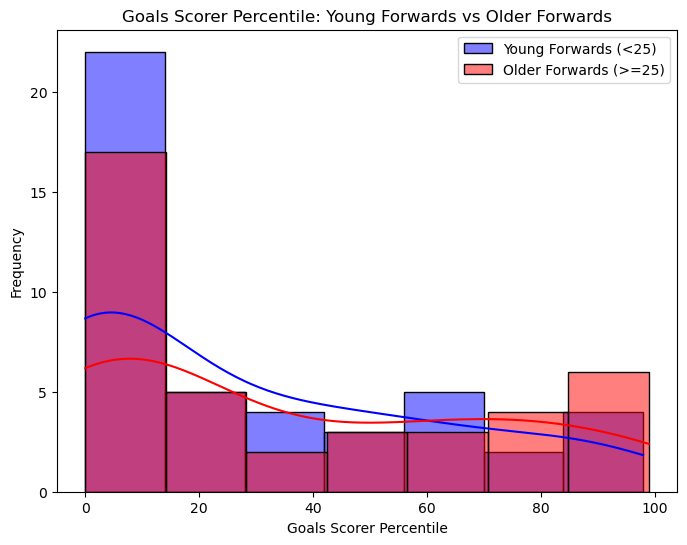

In [358]:
#H₀: Younger forwards score significantly more goals than older forwards.
#H1: There's no significant difference in goals scored by younger and older forwards


# Using only forwards
forwards_df = df2[df2['position'] == 'forward']

# Define young forwards (e.g., age < 25)
young_forwards = forwards_df[forwards_df['Age'] < 25]['Goals']

# Define older forwards (e.g., age >= 25)
older_forwards = forwards_df[forwards_df['Age'] >= 25]['Goals']

# Perform an independent t-test
t_stat, p_value = ttest_ind(young_forwards, older_forwards, equal_var=False)

# Output the t-test results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpretation of the result
if p_value < 0.05:
    print("We reject the null hypothesis (H₀). Younger forwards score significantly more goals than older forwards.")
else:
    print("We fail to reject the null hypothesis (H₀). There's no significant difference in goals scored by younger and older forwards.")

# Plot comparison
plt.figure(figsize=(8, 6))
sns.histplot(young_forwards, color="blue", label="Young Forwards (<25)", kde=True)
sns.histplot(older_forwards, color="red", label="Older Forwards (>=25)", kde=True)
plt.title("Goals Scorer Percentile: Young Forwards vs Older Forwards")
plt.xlabel("Goals Scorer Percentile")
plt.ylabel("Frequency")
plt.legend()
plt.show()


FEATURE ENGINEERING & MACHINE LEARNING:

In [69]:
#Preparing the dataframes for analysis from the cleaned dataframes
df1 = pd.read_csv("for_train1.csv")
df1.head()

,player_name,minutes_played,goals_scored,assists,yellow_cards,red_cards,player_ratings,month,day,opponent,team,score
0,Viktor Gyökeres,90.0,3.0,0.0,0.0,0.0,9.7,Aug,23,Farense,Sporting CP,5.0
1,Viktor Gyökeres,90.0,2.0,0.0,0.0,0.0,9.2,Aug,17,Nacional,Sporting CP,6.0
2,Viktor Gyökeres,90.0,1.0,1.0,0.0,0.0,8.5,Aug,9,Rio Ave,Sporting CP,3.0
3,Viktor Gyökeres,120.0,0.0,2.0,0.0,0.0,8.4,Aug,3,FC Porto,Sporting CP,3.0
4,Viktor Gyökeres,120.0,0.0,0.0,1.0,0.0,8.1,May,26,FC Porto,Sporting CP,1.0


In [70]:
df2= pd.read_csv("outfield_players.csv")
df2

,player_name,team,Height,Age,Market value,Primary,Touches,Shot attempts,Goals,Chances created,Aerial duels won,Defensive actions
0,Viktor Gyökeres,Sporting CP,187,26,66000000.0,Striker,95,95,99,97,46,16
1,Gabri Martinez,Braga,185,21,8000000.0,Left Winger,28,53,59,11,24,36
2,Pedro Goncalves,Sporting CP,173,26,33000000.0,Left Winger,88,97,96,98,8,20
3,Wenderson Galeno,FC Porto,179,26,22000000.0,Left Winger,69,89,98,58,60,53
4,Rodrigo Zalazar,Braga,178,25,3400000.0,Defensive Midfielder,93,96,97,98,60,14
...,...,...,...,...,...,...,...,...,...,...,...,...
282,Ze Vitor,Nacional,183,23,120000.0,Center-back,1,86,97,24,15,5
283,Depu,Gil Vicente,181,24,550000.0,Striker,21,56,45,4,75,3
284,Bernardo Martins,Moreirense,176,26,0.0,Attacking Midfielder,0,0,0,0,0,0
285,Jose Gomes,Nacional,185,28,0.0,Left-back,0,0,0,0,0,0


In [87]:
# Define the mapping lists
forward= ["Striker", "Left Winger","Right Winger", "forward"]
midfielder= ["Defensive Midfielder","Right Midfielder","Left Midfielder","Central Midfielder","Attacking Midfielder", "midfielder"]
defence =["Center-back","Left-back","Right-back", "defender"]

# Create a function to map the positions
def map_position(primary_role):
    if primary_role in forward:
        return 'forward'
    elif primary_role in midfielder:
        return 'midfielder'
    elif primary_role in defence:
        return 'defence'
    else:
        return 'unknown'  # Default case if the role is not found

# Apply the function to create the new 'position' column
df2['position'] = df2['Primary'].apply(map_position)
df2

,player_name,team,Height,Age,Market value,Primary,Touches,Shot attempts,Goals,Chances created,Aerial duels won,Defensive actions,position
0,Viktor Gyökeres,Sporting CP,187,26,66000000.0,Striker,95,95,99,97,46,16,forward
1,Gabri Martinez,Braga,185,21,8000000.0,Left Winger,28,53,59,11,24,36,forward
2,Pedro Goncalves,Sporting CP,173,26,33000000.0,Left Winger,88,97,96,98,8,20,forward
3,Wenderson Galeno,FC Porto,179,26,22000000.0,Left Winger,69,89,98,58,60,53,forward
4,Rodrigo Zalazar,Braga,178,25,3400000.0,Defensive Midfielder,93,96,97,98,60,14,midfielder
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Ze Vitor,Nacional,183,23,120000.0,Center-back,1,86,97,24,15,5,defence
283,Depu,Gil Vicente,181,24,550000.0,Striker,21,56,45,4,75,3,forward
284,Bernardo Martins,Moreirense,176,26,0.0,Attacking Midfielder,0,0,0,0,0,0,midfielder
285,Jose Gomes,Nacional,185,28,0.0,Left-back,0,0,0,0,0,0,defence


In [88]:
df=pd.merge(df1,df2, on = ["player_name"], how = 'left')

In [89]:
df=df.drop(columns=["Primary"])  #converted to position
df=df.drop(columns=["team_y"])      #same as team_x
df= df.rename(columns={"team_x":"team"})
df['disciplinary_actions'] = df['yellow_cards'] + df['red_cards']   #reducing number of columns
df=df.drop(columns=["yellow_cards", "red_cards"])
df['month_num'] = pd.to_datetime(df['month'], format='%b').dt.month   #to convert to cyclical feature 
df= df.drop(columns="month")
df= df.rename(columns={"month_num":"month"})
df['year'] = df['month'].apply(lambda x: 2024 if x <= 9 else 2023)


In [90]:
df= df.drop(columns=["month","day"])  # weak correlation


Correlation Analysis:

In [91]:
df_number= df.select_dtypes(include='number')


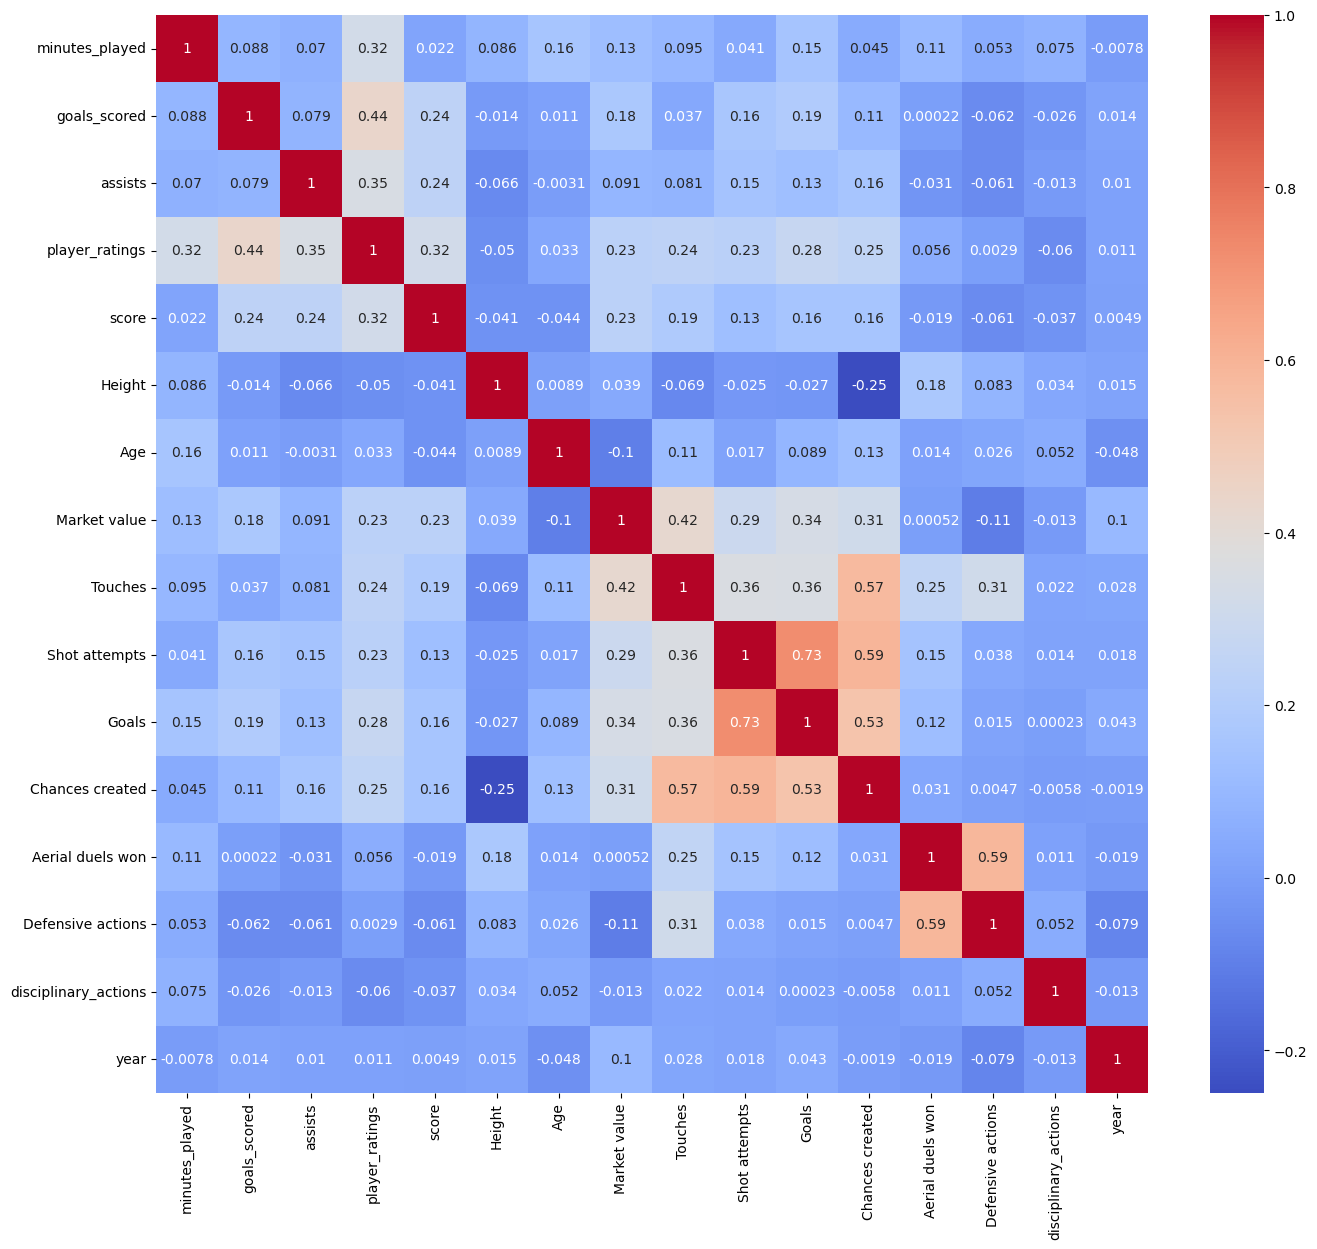

In [92]:
#Correlation Matrix
correlation_matrix = df_number.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [93]:
df_number=df_number.drop(columns=["Shot attempts"])# highly correlated to Goals and less correlated to score among the two.
df_number = df_number.drop(columns = "Aerial duels won") # highly correlated to Defensive actions and less correlated to score
df_number = df_number.drop(columns = "Goals")  # same as above
#Binning Minutes Played
df['minutes'] = pd.cut(df['minutes_played'], bins=[0,30,60,90,120], labels=["hlf_hr","upto_hr","fullgame",'extra'])
df=df.drop(columns = ["minutes_played"])

In [95]:
#Teams in Liga Primeira
opponents = ['Sporting CP', 'Braga', 'FC Porto', 'Famalicao', 'Benfica',
       'Moreirense', 'Santa Clara', 'Gil Vicente', 'Vitoria de Guimaraes',
       'AVS Futebol SAD', 'Boavista', 'Estrela da Amadora', 'Arouca',
       'Casa Pia AC', 'Nacional','Rio Ave', 'Farense', 'Estoril']

In [96]:
df = df[df['opponent'].isin(opponents)]

###Distribution analysis

In [ ]:
# Distribution plots for numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

###CATEGORICAL FEATURE ANALYSIS

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[col])
    plt.title(f'Frequency of Categories in {col}')
    plt.show()

In [100]:
df.dtypes

player_name               object
goals_scored             float64
assists                  float64
player_ratings           float64
opponent                  object
team                      object
score                    float64
Height                   float64
Age                      float64
Market value             float64
Touches                  float64
Shot attempts            float64
Goals                    float64
Chances created          float64
Aerial duels won         float64
Defensive actions        float64
position                  object
disciplinary_actions     float64
year                       int64
minutes                 category
dtype: object

In [101]:
df1= pd.get_dummies(df["position"],dtype=int)

df2= pd.get_dummies(df["minutes"], dtype=int)

df3= pd.get_dummies(df["team"], dtype=int)

df4= pd.get_dummies(df["opponent"],dtype= int)

df_final = pd.concat([df, df1, df3,df4], axis=1)



In [102]:
df_final.columns

Index(['player_name', 'goals_scored', 'assists', 'player_ratings', 'opponent',
       'team', 'score', 'Height', 'Age', 'Market value', 'Touches',
       'Shot attempts', 'Goals', 'Chances created', 'Aerial duels won',
       'Defensive actions', 'position', 'disciplinary_actions', 'year',
       'minutes', 'defence', 'forward', 'midfielder', 'AVS Futebol SAD',
       'Arouca', 'Benfica', 'Boavista', 'Braga', 'Casa Pia AC', 'Estoril',
       'Estrela da Amadora', 'FC Porto', 'Famalicao', 'Farense', 'Gil Vicente',
       'Moreirense', 'Nacional', 'Rio Ave', 'Santa Clara', 'Sporting CP',
       'Vitoria de Guimaraes', 'AVS Futebol SAD', 'Arouca', 'Benfica',
       'Boavista', 'Braga', 'Casa Pia AC', 'Estoril', 'Estrela da Amadora',
       'FC Porto', 'Famalicao', 'Farense', 'Gil Vicente', 'Moreirense',
       'Nacional', 'Rio Ave', 'Santa Clara', 'Sporting CP',
       'Vitoria de Guimaraes'],
      dtype='object')

In [103]:
df_final.drop(columns=["position","team","player_name","opponent","minutes"], inplace=True)
df_final

,goals_scored,assists,player_ratings,score,Height,Age,Market value,Touches,Shot attempts,Goals,...,FC Porto,Famalicao,Farense,Gil Vicente,Moreirense,Nacional,Rio Ave,Santa Clara,Sporting CP,Vitoria de Guimaraes
0,3.0,0.0,9.7,5.0,187.0,26.0,66000000.0,95.0,95.0,99.0,...,0,0,1,0,0,0,0,0,0,0
1,2.0,0.0,9.2,6.0,187.0,26.0,66000000.0,95.0,95.0,99.0,...,0,0,0,0,0,1,0,0,0,0
2,1.0,1.0,8.5,3.0,187.0,26.0,66000000.0,95.0,95.0,99.0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,2.0,8.4,3.0,187.0,26.0,66000000.0,95.0,95.0,99.0,...,1,0,0,0,0,0,0,0,0,0
4,0.0,0.0,8.1,1.0,187.0,26.0,66000000.0,95.0,95.0,99.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,0.0,0.0,6.8,4.0,184.0,32.0,750000.0,67.0,9.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4619,0.0,0.0,5.9,0.0,168.0,24.0,300000.0,23.0,54.0,12.0,...,0,0,0,0,0,0,0,0,0,0
4620,0.0,0.0,6.8,0.0,168.0,24.0,300000.0,23.0,54.0,12.0,...,0,0,0,0,0,0,0,0,0,0
4621,0.0,0.0,6.0,1.0,168.0,24.0,300000.0,23.0,54.0,12.0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df_final.dropna(inplace=True)

#Machine Learning


In [105]:
#Separating  features and target
features = df_final.drop(columns = ["goals_scored"])
target= df_final["goals_scored"]

In [106]:
# Splitting the dataframe for test and train 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 7)


In [107]:
#Scaling the Data using MInMaxScaler
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [108]:
#Scaling the Data using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#KNN

In [110]:
knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train_norm, y_train)


pred = knn.predict(X_test_norm)
print(f"R2-Squared {knn.score(X_test_norm, y_test)}")
print(f"RMSE {mean_squared_error(y_test, pred, squared = False)}")
print(f"MAE {mean_absolute_error(y_test, pred)}")



R2-Squared 0.13629171301446064
RMSE 0.2618655213329954
MAE 0.10950965824665676


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#LINEAR REGRESSION

In [113]:
lin_reg = LinearRegression()

In [114]:
lin_reg.fit(X_train_norm, y_train)

LinearRegression()

In [115]:
pred = lin_reg.predict(X_test_norm)

print(f"R2-Squared {lin_reg.score(X_test_norm, y_test)}")
print(f"RMSE {mean_squared_error(pred,y_test, squared = False)}")
print(f"MAE {mean_absolute_error(pred, y_test)}")

R2-Squared 0.26192509146765697
RMSE 0.2420722450580062
MAE 0.15555494288632987


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#DECISION TREE

In [126]:
tree = DecisionTreeRegressor(max_depth = 10)
tree.fit(X_train_norm, y_train)

DecisionTreeRegressor(max_depth=10)

In [127]:
pred = tree.predict(X_test_norm)
print(f"R2-Squared {tree.score(X_test_norm, y_test)}")
print(f"RMSE {mean_squared_error(pred,y_test, squared = False)}")
print(f"MAE {mean_absolute_error(pred, y_test)}")

R2-Squared 0.3697444078022424
RMSE 0.22369337972980446
MAE 0.06029405207313852


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#RANDOM FOREST

In [130]:
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)

In [131]:
forest.fit(X_train_norm, y_train)

RandomForestRegressor(max_depth=20)

In [132]:
pred = forest.predict(X_test_norm)

print("R2 score", forest.score(X_test_norm, y_test))
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))

R2 score 0.6460536540600668
MAE 0.05895988112927192
RMSE 0.16763453491357602


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [133]:
# XGBOOST
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=100, max_depth = 20)

xgb.fit(X_train_norm, y_train)

pred = xgb.predict(X_test_norm)

print("R2 score", xgb.score(X_test_norm, y_test))
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))


R2 score 0.6201715040992608
MAE 0.04660216926495581
RMSE 0.17365550254888248


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


####TEST

In [138]:
grid = {"n_estimators": [50, 10000]}

In [139]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor())

In [140]:
model = GridSearchCV(estimator = ada_reg, param_grid = grid, cv=3)

In [141]:
model.fit(X_train_norm, y_train)

In [142]:
model.best_params_

{'n_estimators': 50}

In [143]:
best_model = model.best_estimator_

In [144]:
pred = best_model.predict(X_test_norm)

print("R2 score", best_model.score(X_test_norm, y_test))
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))


R2 score 0.606979977753059
MAE 0.031203566121842496
RMSE 0.17664531163278152


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#RANDOM SEARCH

In [147]:
grid = {"n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        "estimator__max_leaf_nodes": [int(x) for x in np.linspace(start = 500, stop = 3000, num = 10)],
        "estimator__max_depth":[int(x) for x in np.linspace(10, 110, num = 11)]}

In [148]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor())
model = RandomizedSearchCV(estimator = ada_reg, param_distributions = grid, n_iter = 10, cv = 5, n_jobs = -1)

In [149]:
model.fit(X_train_norm, y_train)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor()),
                   n_jobs=-1,
                   param_distributions={'estimator__max_depth': [10, 20, 30, 40,
                                                                 50, 60, 70, 80,
                                                                 90, 100, 110],
                                        'estimator__max_leaf_nodes': [500, 777,
                                                                      1055,
                                                                      1333,
                                                                      1611,
                                                                      1888,
                                                                      2166,
                                                                      2444,
                                                                      2722,
                                                                      3000],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]})

In [150]:
model.best_params_

{'n_estimators': 200,
 'estimator__max_leaf_nodes': 1611,
 'estimator__max_depth': 10}

In [151]:
best_model = model.best_estimator_

In [152]:
pred = best_model.predict(X_test_norm)

print("R2 score", best_model.score(X_test_norm, y_test))
print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))


R2 score 0.5892309382874863
MAE 0.07166135358277907
RMSE 0.18058997600690968


c:\Users\shyam\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
